In [100]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr
!apt-get install -y tesseract-ocr
!sudo apt-get install -y tesseract-ocr-kor
!sudo apt-get install libtesseract-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-kor is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [199]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
from google.colab.patches import cv2_imshow


plt.style.use('dark_background')

# os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata/'

In [267]:
img_ori = cv2.imread('platecar1.jpg')

if img_ori is None:
    print("이미지를 불러올 수 없습니다. 경로를 확인하세요.")
else:
    height, width, channel = img_ori.shape
    plt.figure(figsize=(12, 10))
    plt.imshow(img_ori, cmap='gray')
    print(height, width, channel)

4032 3024 3


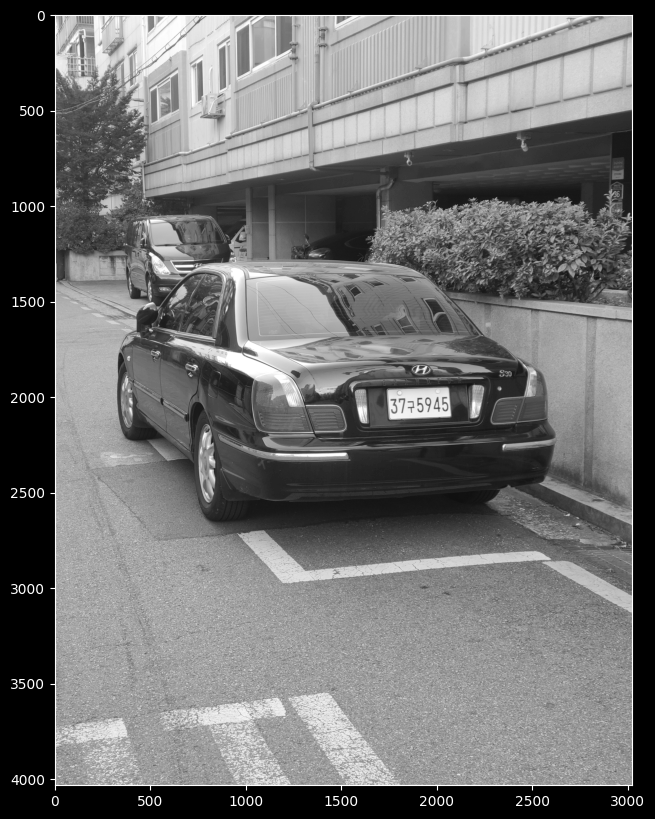

In [268]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

In [269]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=9,
    C=9
)

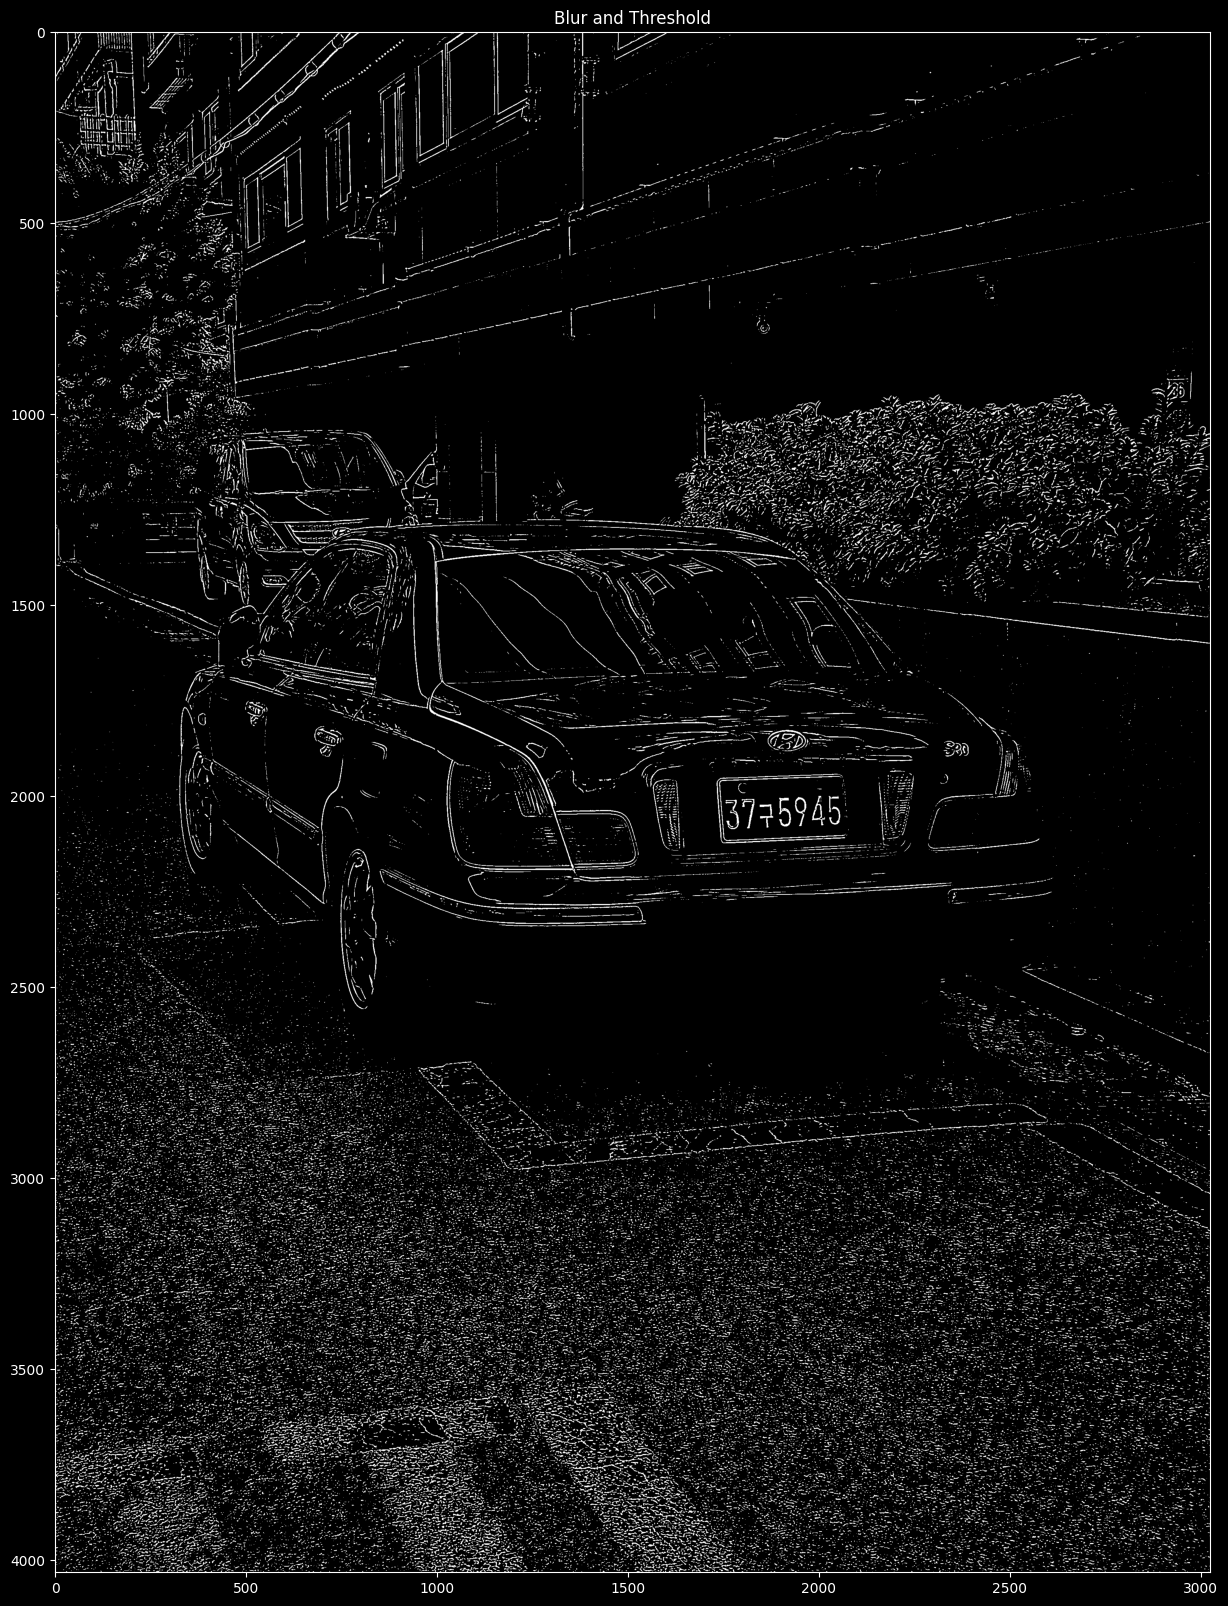

In [270]:
plt.figure(figsize=(20,20))
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

In [271]:
# contours, _ = cv2.findContours(
#     img_blur_thresh,
#     mode=cv2.RETR_LIST,
#     method=cv2.CHAIN_APPROX_SIMPLE
# )
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_TREE,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

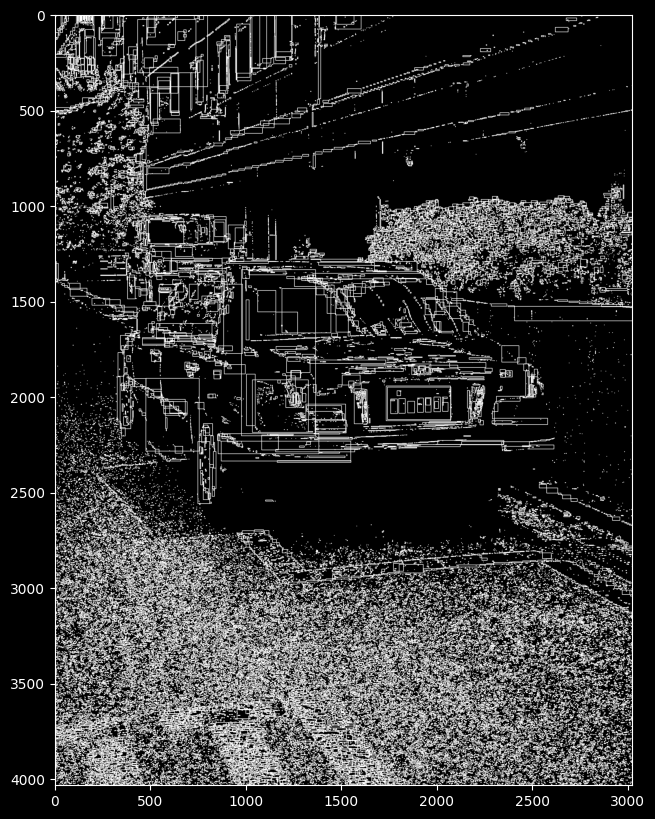

In [272]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

In [273]:
MIN_AREA = 250
MIN_WIDTH, MIN_HEIGHT=10, 20
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

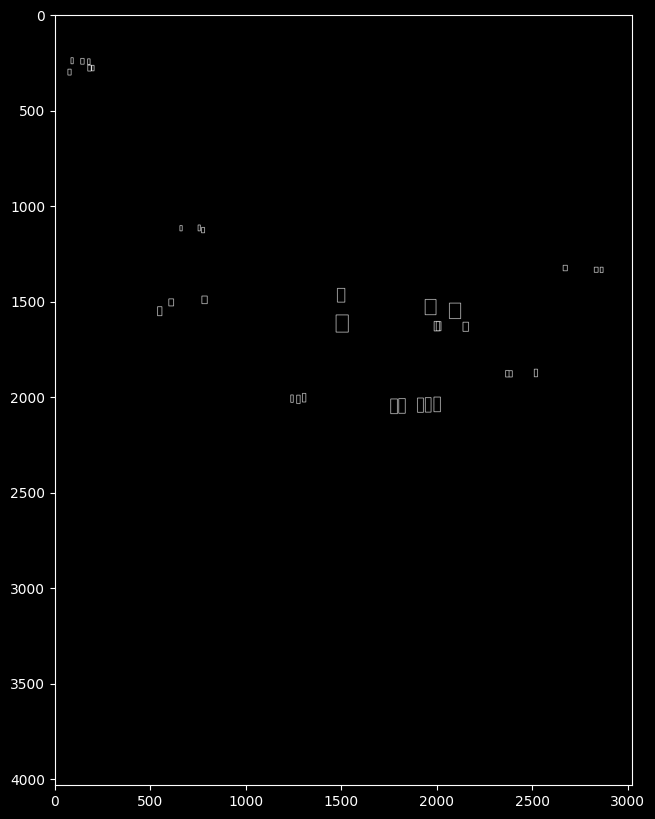

In [274]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 18.0
MAX_AREA_DIFF = 0.4
MAX_WIDTH_DIFF = 0.4
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3
MAX_N_MATCHED = 10
MIN_DISTANCE = 1  # 최소 간격 설정

def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))

            # 최소 거리 조건 추가
            if distance < MIN_DISTANCE:
              continue  # 간격이 너무 짧은 contour는 제외
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED or len(matched_contours_idx) > MAX_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

In [278]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.7
MIN_PLATE_RATIO = 2
MAX_PLATE_RATIO = 10

MARGIN = 5  # 여유 공간을 위해 추가할 Margin 값
SCALE_FACTOR = 0.7  # 이미지 크기를 약간 더 작게 만들기 위한 배율

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_blur_thresh, M=rotation_matrix, dsize=(width, height))

    # Margin을 추가한 크기로 이미지 추출
    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width + MARGIN * 2), int(plate_height + MARGIN * 2)),
        center=(int(plate_cx), int(plate_cy))
    )

    # ROI 크기 조정 (작게 만들기 위해 SCALE_FACTOR 적용)
    img_cropped_resized = cv2.resize(img_cropped, (0, 0), fx=SCALE_FACTOR, fy=SCALE_FACTOR)

    # 비율 검사를 올바르게 수정
    plate_ratio = img_cropped_resized.shape[1] / img_cropped_resized.shape[0]
    if not (MIN_PLATE_RATIO <= plate_ratio <= MAX_PLATE_RATIO):
        continue

    # if img_cropped_resized.shape[1] / img_cropped_resized.shape[0] < MIN_PLATE_RATIO or img_cropped_resized.shape[1] / img_cropped_resized.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
    #     continue

    plate_imgs.append(img_cropped_resized)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped_resized, cmap='gray')

In [279]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    # 번호판 후보 영역 확대
    # 패딩된 번호판 이미지를 사용하여 OCR 처리
    # 그레이스케일로 변환
    _, thresh_img = cv2.threshold(plate_img, 150, 255, cv2.THRESH_BINARY)

    # plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=4, fy=4)
    # _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # # find contours again (same as above)
    # contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    # plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    # plate_max_x, plate_max_y = 0, 0

    # for contour in contours:
    #     x, y, w, h = cv2.boundingRect(contour)

    #     area = w * h
    #     ratio = w / h

    #     if area > MIN_AREA \
    #     and w > MIN_WIDTH and h > MIN_HEIGHT \
    #     and MIN_RATIO < ratio < MAX_RATIO:
    #         if x < plate_min_x:
    #             plate_min_x = x
    #         if y < plate_min_y:
    #             plate_min_y = y
    #         if x + w > plate_max_x:
    #             plate_max_x = x + w
    #         if y + h > plate_max_y:
    #             plate_max_y = y + h

    # img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    # 여기서 더 이상 컨투어를 사용하지 않고, 그대로 OCR 진행

    img_result = cv2.GaussianBlur(plate_img, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=5, bottom=5, left=5, right=5, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))


  # Tesseract OCR을 사용하여 번호판 텍스트 추출
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 6 --oem 3 --dpi 300')


    result_chars = ''
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            result_chars += c
    print(result_chars)
    plate_chars.append(result_chars)


    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')



13775945
0


개네22
024
시
이모치1106
티티


## 번호판에서 바로 text 추출하기


In [ ]:
direct_plate = cv2.imread('37구3945.png')
#pytesseract에서는 numpy array를 읽지 못하고 file을 읽기 때문에 os로 파일을 불러들여야 한다.
# Optional: Apply some preprocessing like thresholding to improve OCR results
gray = cv2.cvtColor(direct_plate, cv2.COLOR_BGR2GRAY)
_, thresh_img = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Save temporarily as pytesseract cannot process numpy arrays directly
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, thresh_img)

text = pytesseract.image_to_string(Image.open(filename), lang = 'kor')
os.remove(filename)

#결과를 보자.

print(text)
cv2_imshow(direct_plate)

## Contour 찾기와 OCR을 동시에!


20002이0녀


<ipython-input-19-7949404d665a>:85: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(plate_imgs), 1, min(i+1, len(plate_imgs)))


0002004


<ipython-input-19-7949404d665a>:85: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(plate_imgs), 1, min(i+1, len(plate_imgs)))


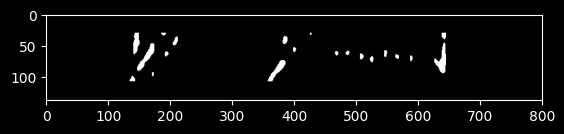

In [19]:
# PLATE_WIDTH_PADDING = 1.5 # 1.3 -> 1.5
# PLATE_HEIGHT_PADDING = 1.7 # 1.5 -> 1.7
# MIN_PLATE_RATIO = 3
# MAX_PLATE_RATIO = 10

# plate_imgs = []
# # plate_infos = []
# plate_chars = []
# longest_idx, longest_text = -1, 0

# for i, matched_chars in enumerate(matched_result):
#     sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

#     plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
#     plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

#     plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

#     sum_height = 0
#     for d in sorted_chars:
#         sum_height += d['h']

#     plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

#     triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
#     triangle_hypotenus = np.linalg.norm(
#         np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
#         np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
#     )

#     angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

#     rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

#     img_rotated = cv2.warpAffine(img_blur_thresh, M=rotation_matrix, dsize=(width, height))

#     img_cropped = cv2.getRectSubPix(
#         img_rotated,
#         patchSize=(int(plate_width), int(plate_height)),
#         center=(int(plate_cx), int(plate_cy))
#     )

#     if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
#         continue

#     plate_imgs.append(img_cropped)

#     # 패딩된 번호판 이미지를 사용하여 OCR 처리
#     plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=3, fy=3)
#     _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#     # 여기서 더 이상 컨투어를 사용하지 않고, 그대로 OCR 진행

#     img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
#     _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     img_result = cv2.copyMakeBorder(img_result, top=5, bottom=5, left=5, right=5, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))


#   # Tesseract OCR을 사용하여 번호판 텍스트 추출
#     chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 3 --dpi 300')


#     result_chars = ''
#     has_digit = False
#     for c in chars:
#         if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
#             if c.isdigit():
#                 has_digit = True
#             result_chars += c

#     print(result_chars)
#     plate_chars.append(result_chars)


#     # plate_infos.append({
#     #     'x': int(plate_cx - plate_width / 2),
#     #     'y': int(plate_cy - plate_height / 2),
#     #     'w': int(plate_width),
#     #     'h': int(plate_height)
#     # })


#     # subplot 그리기
#     if len(plate_imgs) > 1:  # plate_imgs의 길이가 1보다 클 때만 subplot 사용
#         plt.subplot(len(plate_imgs), 1, min(i+1, len(plate_imgs)))
#     else:
#         plt.figure()  # plate_imgs가 1개일 때는 figure로 그리기
#     plt.imshow(img_result, cmap='gray')

#     if has_digit and len(result_chars) > longest_text:
#         longest_idx = i